## Ad-Hoc E-commerce Data Exploration and Visualization

### Importing necessary libraries and data

In [ ]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

In [82]:
df = pd.read_csv('ecommerce_product_sales.csv')
df.head(10)

,Sale ID,Product Name,Category,Price,Quantity,Customer Age,Customer Gender,Discount,Payment Method,Region,Sale Date,Total Sales
0,1,Smartphone,Electronics,109.89,3,57,Male,0.23,Debit Card,South America,2024-02-13,253.85
1,2,Smartwatch,Electronics,370.32,3,19,Female,0.23,Debit Card,South America,2023-09-18,855.44
2,3,Smartwatch,Electronics,1308.22,3,27,Male,0.11,PayPal,Asia,2024-07-13,3492.95
3,4,Laptop,Electronics,328.62,5,52,Male,0.05,Debit Card,South America,2023-02-13,1560.94
4,5,Laptop,Electronics,829.22,8,21,Female,0.07,Credit Card,Africa,2024-01-07,6169.40
5,6,Smartphone,Electronics,1221.73,1,64,Male,0.06,Bank Transfer,Asia,2024-04-12,1148.43
6,7,Smartphone,Electronics,788.71,9,20,Female,0.20,Debit Card,Africa,2024-09-21,5678.71
7,8,Tablet,Electronics,715.71,4,53,Female,0.10,Bank Transfer,Asia,2024-09-18,2576.56
8,9,Smartphone,Electronics,1454.69,7,20,Male,0.22,Bank Transfer,Asia,2024-03-21,7942.61
9,10,Headphones,Accessories,1017.56,7,54,Female,0.08,Debit Card,Europe,2024-05-04,6553.09


In [83]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 20000 entries, 0 to 19999
Data columns (total 12 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   Sale ID          20000 non-null  int64  
 1   Product Name     20000 non-null  object 
 2   Category         20000 non-null  object 
 3   Price            20000 non-null  float64
 4   Quantity         20000 non-null  int64  
 5   Customer Age     20000 non-null  int64  
 6   Customer Gender  20000 non-null  object 
 7   Discount         20000 non-null  float64
 8   Payment Method   20000 non-null  object 
 9   Region           20000 non-null  object 
 10  Sale Date        20000 non-null  object 
 11  Total Sales      20000 non-null  float64
dtypes: float64(3), int64(3), object(6)
memory usage: 1.8+ MB


In [84]:
df['Product Name'].value_counts()

Product Name
Smartwatch    4134
Tablet        4012
Smartphone    3980
Headphones    3948
Laptop        3926
Name: count, dtype: int64

In [85]:
df['Sale Date'] = pd.to_datetime(df['Sale Date'])
df['Month'] = df['Sale Date'].dt.month
df['Day'] = df['Sale Date'].dt.day
df['Year'] = df['Sale Date'].dt.year
df['Day of Week'] = df['Sale Date'].dt.dayofweek
df['Quarter'] = df['Sale Date'].dt.quarter

### Functions for getting insights

#### Demographic Insights

In [ ]:
# Creating Age Groups

bins = [18, 25, 35, 45, 55, 65]

labels = ['18-25', '26-35', '36-45', '46-55', '56-65']

df['Age Group'] = pd.cut(df['Customer Age'], bins = bins, labels = labels, right = False)

def analyze_demographics(df):
    # Spending by Age Group
    age_spending = df.groupby('Age Group').agg(
            Avg_Total_Sales = ('Total Sales', 'mean'),
            Median_Total_Sales = ('Total Sales', 'median'),
            Count = ('Sale ID', 'count')
    ).sort_values('Avg_Total_Sales', ascending=False)
    
    # Gender Comparison
    gender_spending = df.groupby('Customer Gender').agg(
            Avg_Spend = ('Total Sales', 'mean'),
            Purchase_Count = ('Sale ID', 'count'),
            Avg_Quantity = ('Quantity', 'mean')
    )
    
    # Age group vs product categories
    age_category = pd.pivot_table( df, values='Total Sales',
                                  index = 'Age Group',
                                  columns='Category',
                                  aggfunc='sum').fillna(0)
    
    return age_spending, gender_spending, age_category

#### Regional Performance

In [87]:
def analyze_regional(df):
    # Regional Sales Performance
    region_stats = df.groupby('Region').agg(
            Total_Sales = ('Total Sales', 'sum'),
            Avg_Sale_Per_Customer = ('Total Sales', 'mean'),
            Customer_Count = ('Sale ID', 'count'),
            Avg_Discount = ('Discount', 'mean')
    ).sort_values('Total_Sales', ascending = False)
    
    # Discount effectiveness by region
    discount_effect = df.groupby(['Region', pd.cut(df['Discount'], bins=[0, 0.1, 0.2, 0.3])]).agg(
            Avg_Sales = ('Total Sales', 'mean'),
            Count = ('Sale ID', 'count')
    ).reset_index()
    discount_effect['Discount_Mid'] = discount_effect['Discount'].apply(lambda interval: interval.mid)
    
    return region_stats, discount_effect

#### Product-Level Insights

In [88]:
def analyze_products(df):
    # Top Products by revenue and quantity
    top_products = df.groupby('Product Name').agg(
            Total_Revenue=('Total Sales', 'sum'),
            Total_Quantity = ('Quantity', 'sum'),
            Avg_Price = ('Price', 'mean')
    ).sort_values('Total_Revenue', ascending=False)
    
    # Price sensitivity analysis
    price_bins = [50, 200, 400, 600, 800, 1000, 1200, 1500]
    price_segments = df.groupby(pd.cut(df['Price'], bins=price_bins)).agg(
            Total_Quantity=('Quantity', 'sum'),
            Avg_Discount = ('Discount', 'mean'),
            Num_Products = ('Product Name', 'nunique')
    )
    
    return top_products, price_segments

#### Discount Effectiveness

In [89]:
def analyze_discounts(df):
    # Discount vs Sales correlation
    discount_corr = df[['Discount', 'Total Sales', 'Quantity']].corr()
    
    # Optimal discount analysis
    discount_bins = [0, 0.05, 0.1, 0.15, 0.2, 0.25, 0.3]
    discount_groups = df.groupby(pd.cut(df['Discount'], bins=discount_bins)).agg(
        Avg_Sales = ('Total Sales', 'mean'),
        Total_Quantity = ('Quantity', 'sum'),
        Count = ('Sale ID', 'count')
    )
    
    return discount_corr, discount_groups

#### Seasonality Analysis

In [90]:
def analyze_seasonality(df):
    # Monthly
    monthly = df.groupby('Month').agg(
        Total_Sales=('Total Sales', 'sum'),
        Avg_Sales=('Total Sales', 'mean'),
        Transaction_Count=('Sale ID', 'count')
    )
    
    # Day of week trends
    dow_map = {0: 'Monday', 1:'Tuesday', 2:'Wednesday', 3:'Thursday', 4:'Friday', 5:'Saturday', 6:'Sunday'}
    
    df['Day of Week Name'] = df['Day of Week'].map(dow_map)
    
    dow = df.groupby('Day of Week Name').agg(
        Total_Sales = ('Total Sales', 'sum'),
        Avg_Sales = ('Total Sales', 'mean')
    ).reindex(list(dow_map.values()))
    
    # Quarterly Trends
    quarterly = df.groupby('Quarter').agg(
        Total_Sales=('Total Sales', 'sum'),
        Avg_Sales = ('Total Sales', 'mean')
    )
    
    return monthly, dow, quarterly

### Visualization Functions

In [91]:
def plot_demographics(age_spending, gender_spending, age_category):
    fig, axes = plt.subplots(2, 2, figsize=(16, 12))
    
    # Age Group Spending
    sns.barplot(x = age_spending.index, y='Avg_Total_Sales', data=age_spending, ax=axes[0, 0], palette='viridis')
    axes[0,0].set_title('Average Total Sales by Age Group')
    axes[0,0].set_ylabel('Average Sales ($)')
    
    # Gender Spending
    gender_spending['Avg_Spend'].plot(kind = 'bar', ax=axes[0,1], color=['pink', 'lightblue'])
    axes[0,1].set_title('Average Spending by Gender')
    axes[0,1].set_ylabel('Average Sales ($)')
    
    # Age vs Category distribution
    sns.heatmap(age_category, annot=True, fmt='.0f', cmap='YlGnBu', ax = axes[1,0])
    axes[1,0].set_title('Total Sales by Age Group and Category')
    
    # Age group distribution
    age_counts = df['Age Group'].value_counts().sort_index()
    age_counts.plot(kind='pie',autopct='%1.1f%%', ax=axes[1,1])
    axes[1,1].set_title('Customer Age Distribution')
    
    plt.tight_layout()
    plt.show()
    
    return fig
    
    
def plot_regional(region_stats, discount_effect):
    fig, axes = plt.subplots(1, 2, figsize=(16,6))
    
    # Regional Sales
    region_stats['Total_Sales'].sort_values().plot(kind='barh', ax=axes[0], color='teal')
    axes[0].set_title('Total Sales by Region')
    axes[0].set_xlabel('Total Sales ($)')
    
    # Discount effectiveness
    sns.lineplot(x='Discount_Mid', y='Avg_Sales', hue='Region',
                    data=discount_effect, ax=axes[1], marker='o')
    axes[1].set_title('Discount Effectiveness by Region')
    axes[1].set_ylabel('Average Sales ($)')
    axes[1].set_xlabel('Discount Range')
    
    plt.tight_layout
    plt.show()
    
    return fig
    
    
def plot_products(top_products, price_segments):
    fig, axes = plt.subplots(3, 1, figsize=(16, 12))
    
    # Top 10 products by revenue
    top_products.head(10)['Total_Revenue'].sort_values().plot(
        kind='barh', ax= axes[1], color = 'navy'
    )
    axes[1].set_title('Top 10 Products by Revenue')
    axes[1].set_xlabel('Total Revenue ($)')
    
    # Top 10 products by quantity
    
    top_products.sort_values('Total_Quantity', ascending=False).head(10)['Total_Quantity'].sort_values().plot(
        kind='barh', ax=axes[2], color='green'
    )
    axes[2].set_title('Top 10 Products by Quantity Sold')
    axes[2].set_xlabel('Total Quantity Sold')
    
    
    # Price Distribution
    sns.histplot(df['Price'], bins=20, kde=True, ax=axes[0], color='purple')
    axes[0].set_title('Price Distribution')
    axes[0].set_xlabel('Price ($)')
    
    plt.tight_layout()
    plt.show()
    
    return fig
    
    
def plot_discounts(discount_corr, discount_groups):
    fig, axes = plt.subplots(1, 2, figsize=(16, 6))
    
    # Discount Correlation Heatmap
    sns.heatmap(discount_corr, annot=True, cmap='coolwarm', ax=axes[0])
    axes[0].set_title('Discount Correlation Matrix')
    
    # Discount effectiveness
    discount_groups['Avg_Sales'].plot(kind='line', marker='o', ax=axes[1], color='red')
    axes[1].set_title('Average Sales by Discount Range')
    axes[1].set_ylabel('Average Sales ($)')
    axes[1].set_xlabel('Discount Range')
    
    plt.tight_layout()
    plt.show()
    
    return fig
    
    
def plot_seasonality(monthly, dow, quarterly):
    fig, axes = plt.subplots(2, 2, figsize=(16,6))
    
    # Monthly trends
    monthly['Total_Sales'].plot(kind = 'line', marker='o', ax=axes[0,0], color='blue')
    axes[0,0].set_title('Monthly Sales Trends')
    axes[0,0].set_ylabel('Total Sales ($)')
    axes[0,0].set_xticks(range(1,13))
    
    # Day of week trends
    dow['Total_Sales'].plot(kind='bar', ax=axes[0,1], color='orange')
    axes[0,1].set_title('Sales by Day of Week')
    axes[0,1].set_ylabel('Total Sales ($)')
    
    # Quarterly trends
    quarterly['Total_Sales'].plot(kind='pie', autopct='%1.1f%%', ax=axes[1,0])
    axes[1,0].set_title('Quarterly Sales Distribution')
    
    # Transaction count by month
    monthly['Transaction_Count'].plot(kind='bar', ax=axes[1,1], color='green')
    axes[1,1].set_title('Transaction Count by Month')
    axes[1,1].set_ylabel('Number of Transactions')
    
    plt.tight_layout()
    plt.show()
    
    return fig
    
    

### Execution of functions

In [92]:
age_spending, gender_spending, age_category = analyze_demographics(df)
region_stats, discount_effect = analyze_regional(df)
top_products, price_segments = analyze_products(df)
discount_corr, discount_groups = analyze_discounts(df)
monthly, dow, quarterly = analyze_seasonality(df)

C:\Users\bhush\AppData\Local\Temp\ipykernel_4800\2541966490.py:13: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  age_spending = df.groupby('Age Group').agg(
C:\Users\bhush\AppData\Local\Temp\ipykernel_4800\2541966490.py:27: FutureWarning: The default value of observed=False is deprecated and will change to observed=True in a future version of pandas. Specify observed=False to silence this warning and retain the current behavior
  age_category = pd.pivot_table( df, values='Total Sales',
C:\Users\bhush\AppData\Local\Temp\ipykernel_4800\770229719.py:11: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  discount_effe

C:\Users\bhush\AppData\Local\Temp\ipykernel_4800\1417402765.py:5: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x = age_spending.index, y='Avg_Total_Sales', data=age_spending, ax=axes[0, 0], palette='viridis')


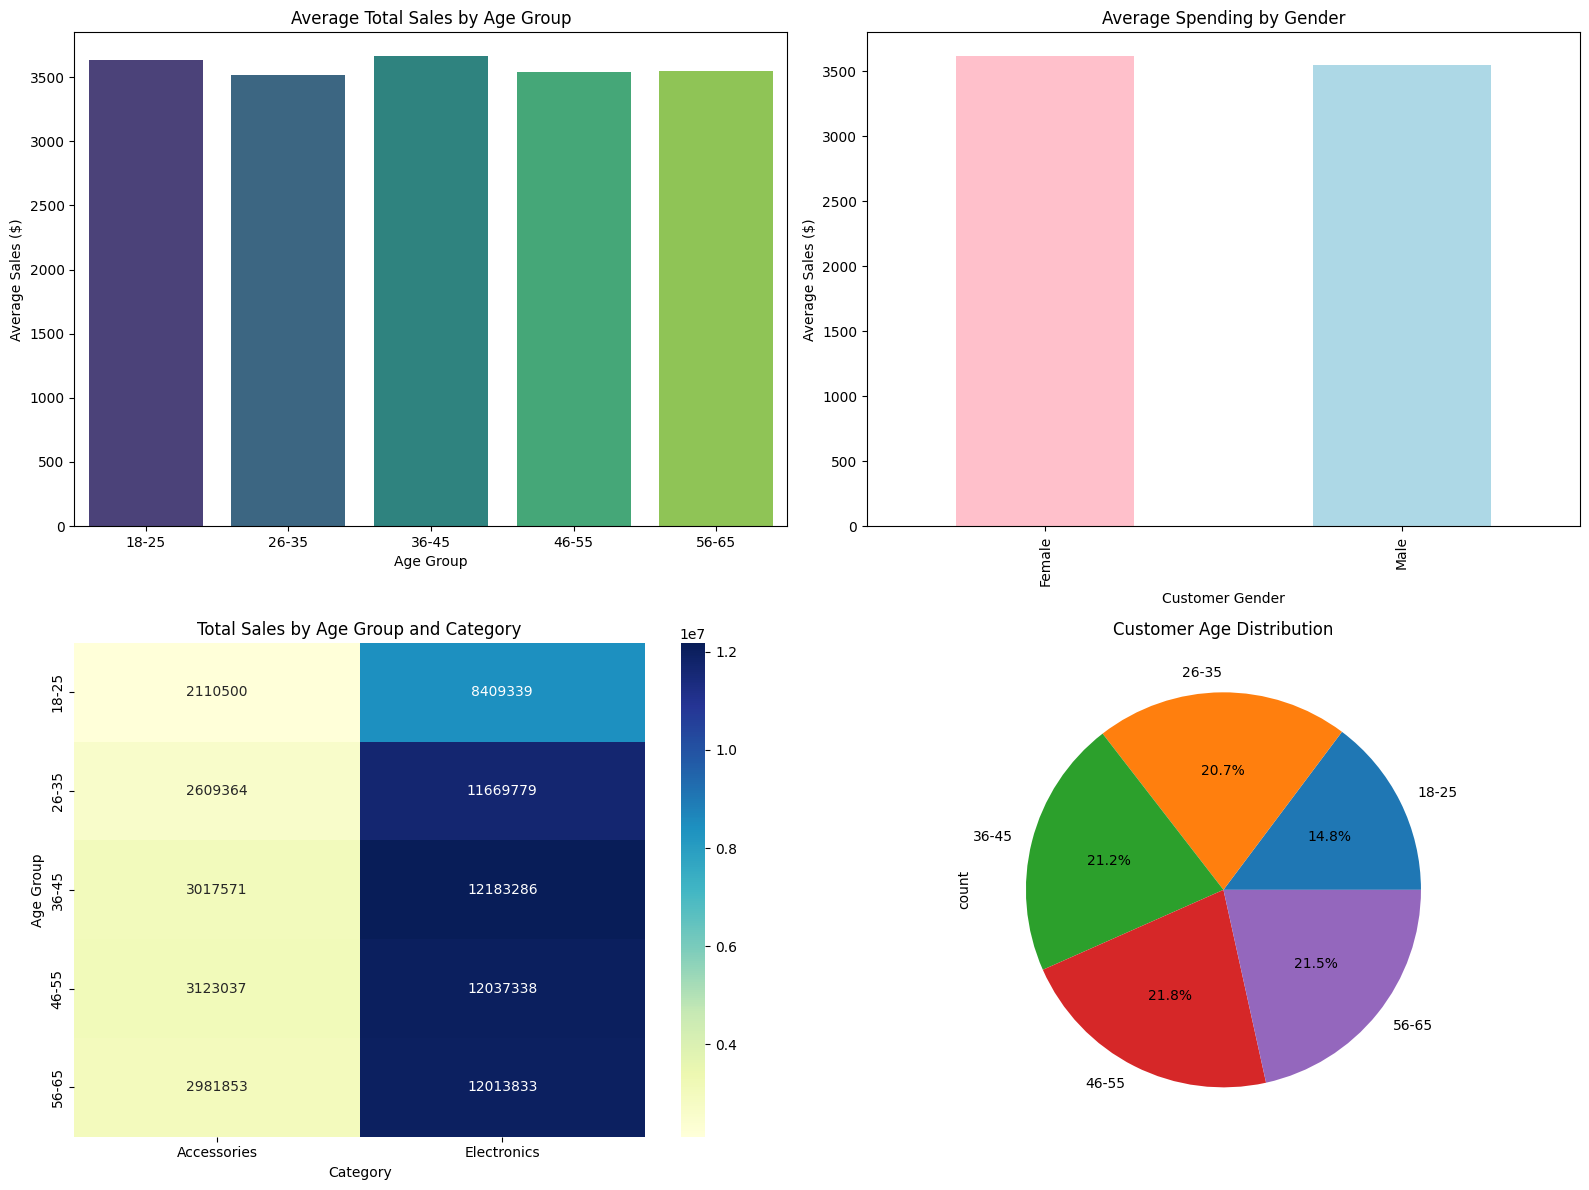

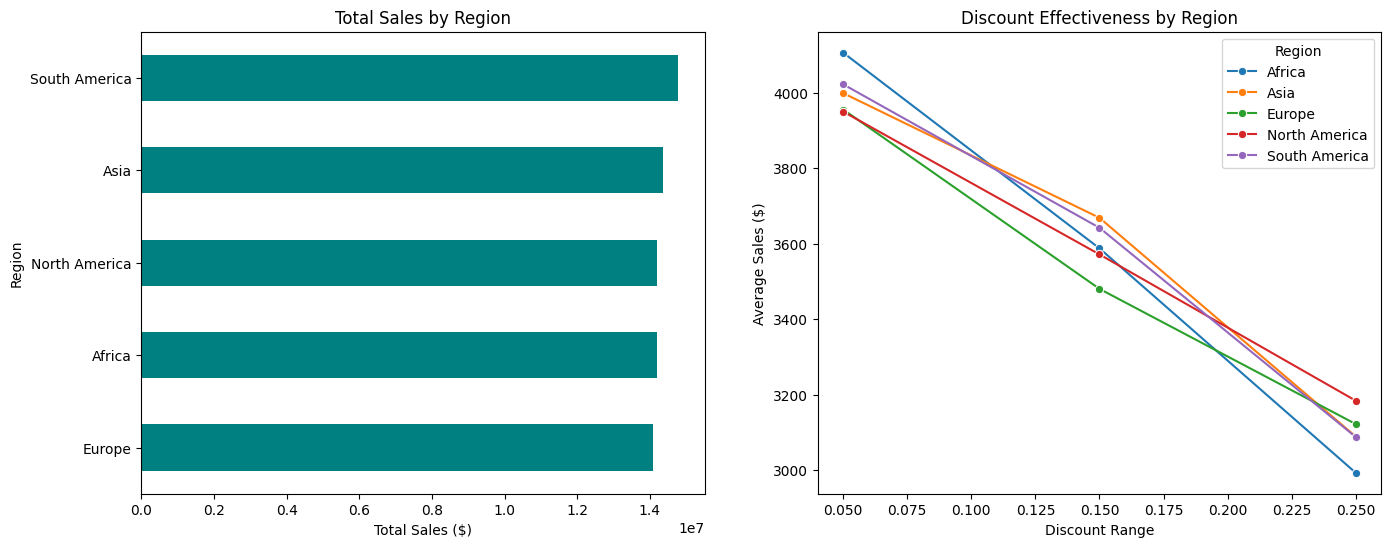

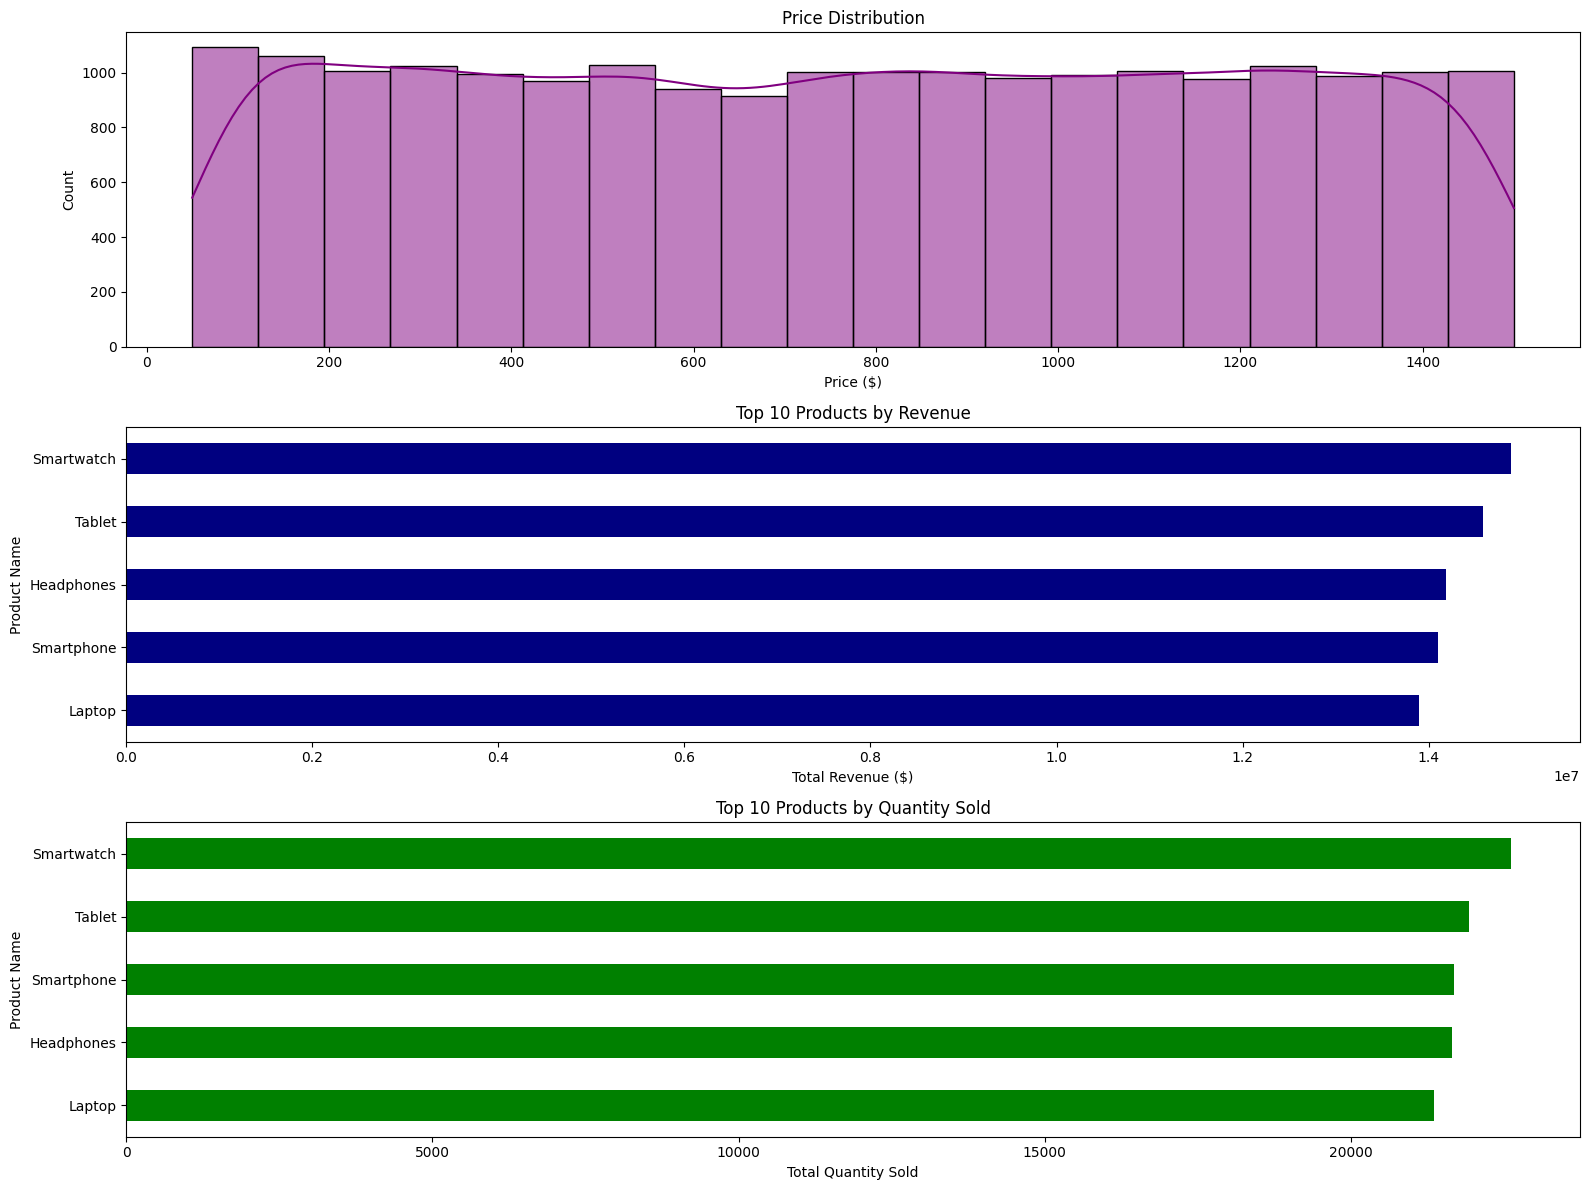

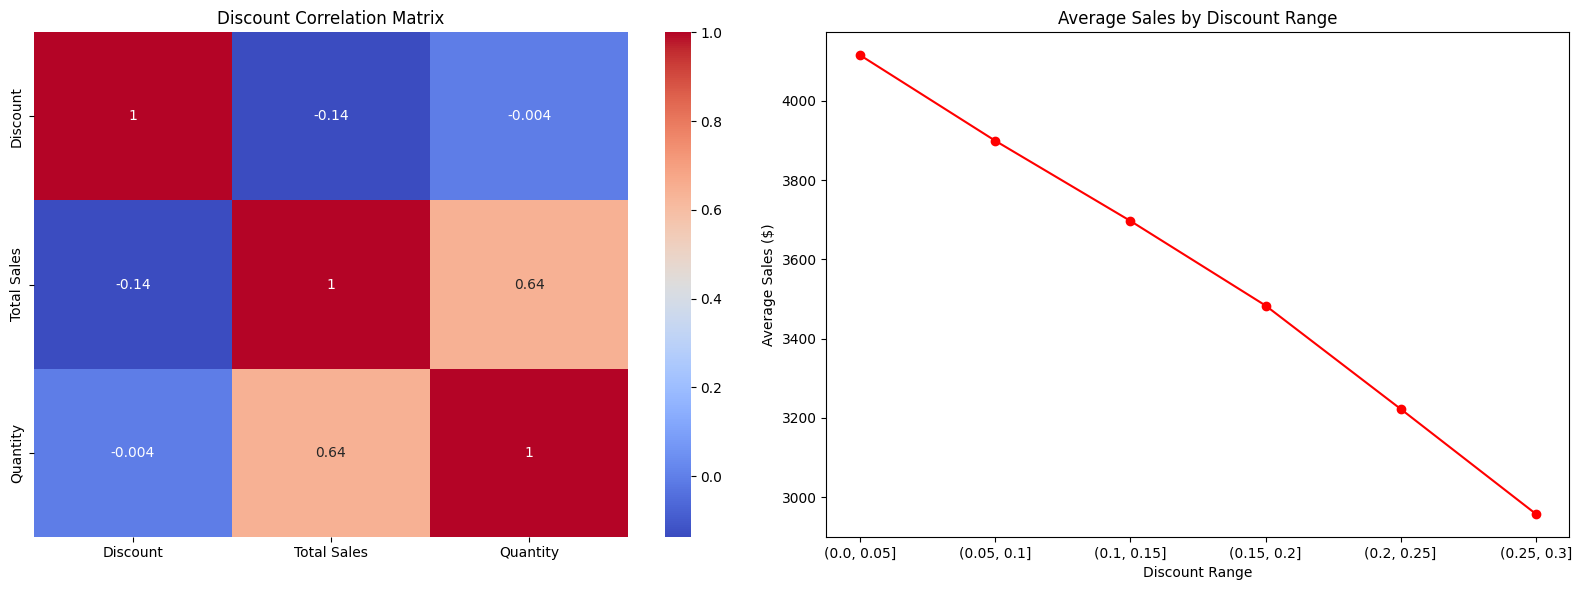

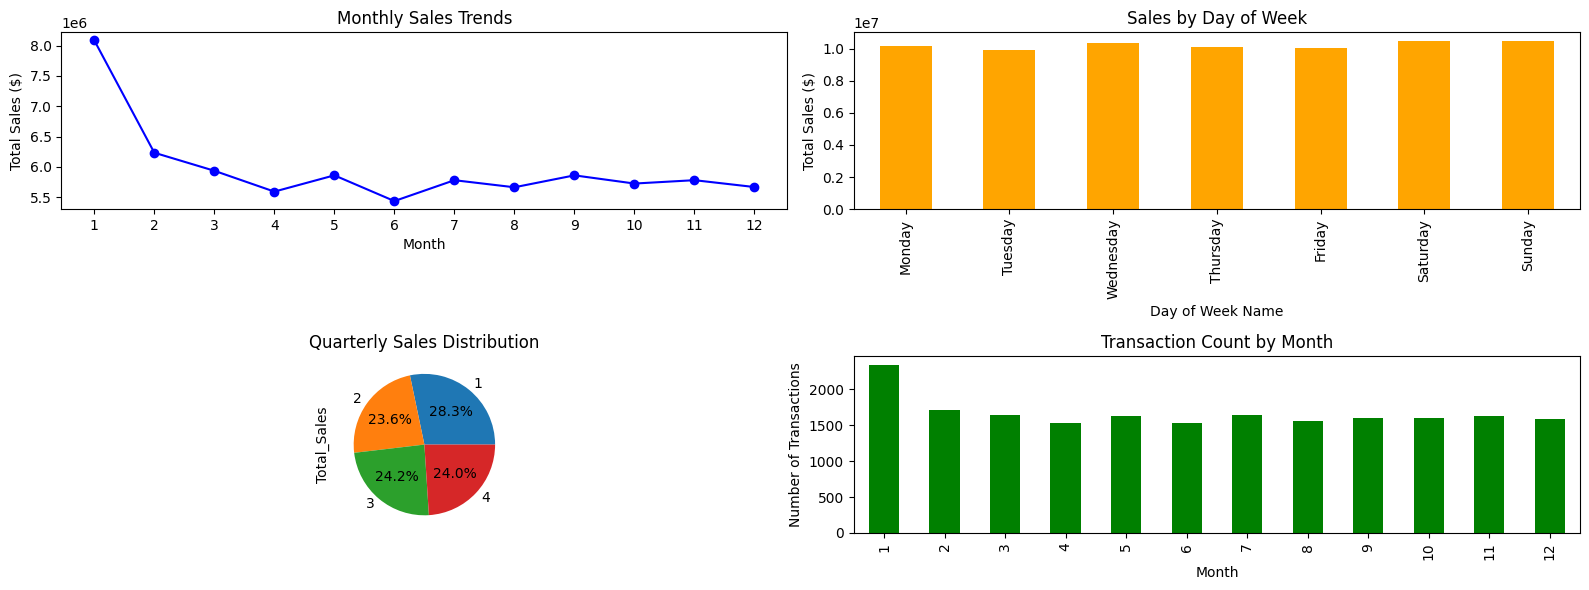

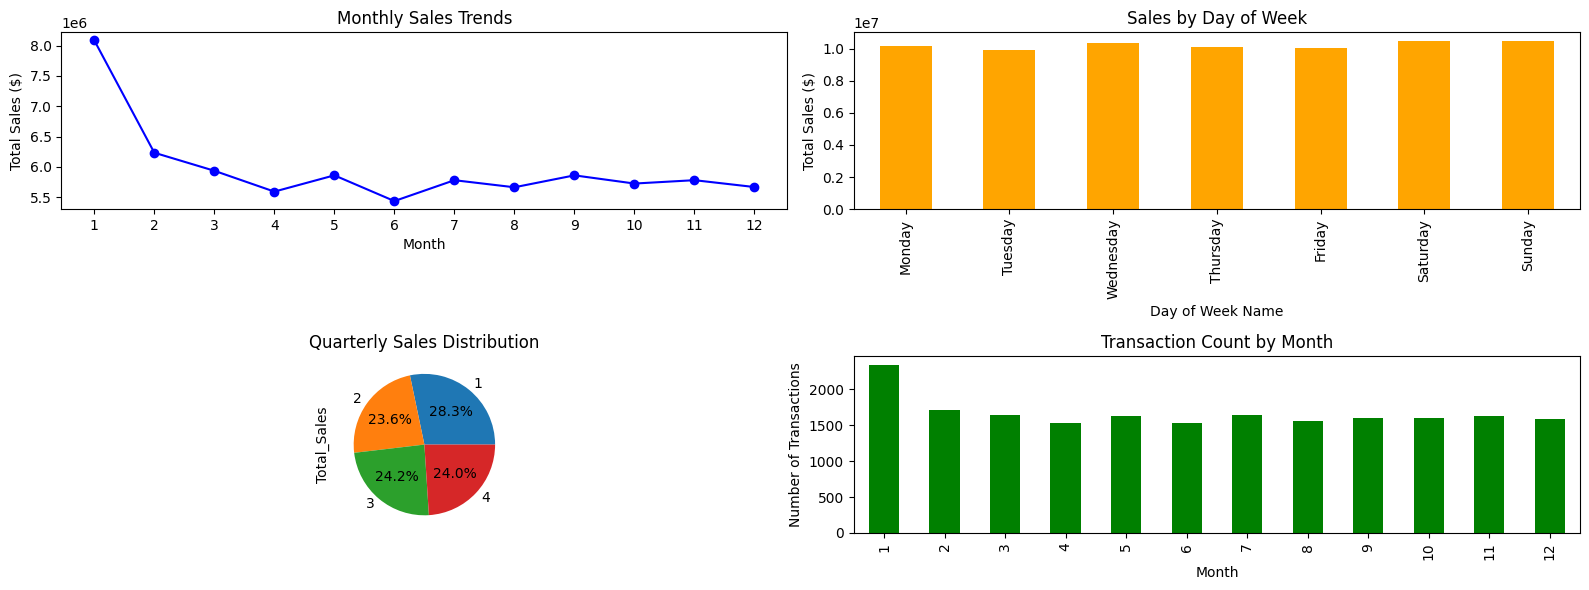

In [93]:
plot_demographics(age_spending, gender_spending, age_category)
plot_regional(region_stats, discount_effect)
plot_products(top_products, price_segments)
plot_discounts(discount_corr, discount_groups)
plot_seasonality(monthly, dow, quarterly)

### Creating PDF file to save our plots!

In [94]:
from matplotlib.backends.backend_pdf import PdfPages

C:\Users\bhush\AppData\Local\Temp\ipykernel_4800\1417402765.py:5: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x = age_spending.index, y='Avg_Total_Sales', data=age_spending, ax=axes[0, 0], palette='viridis')


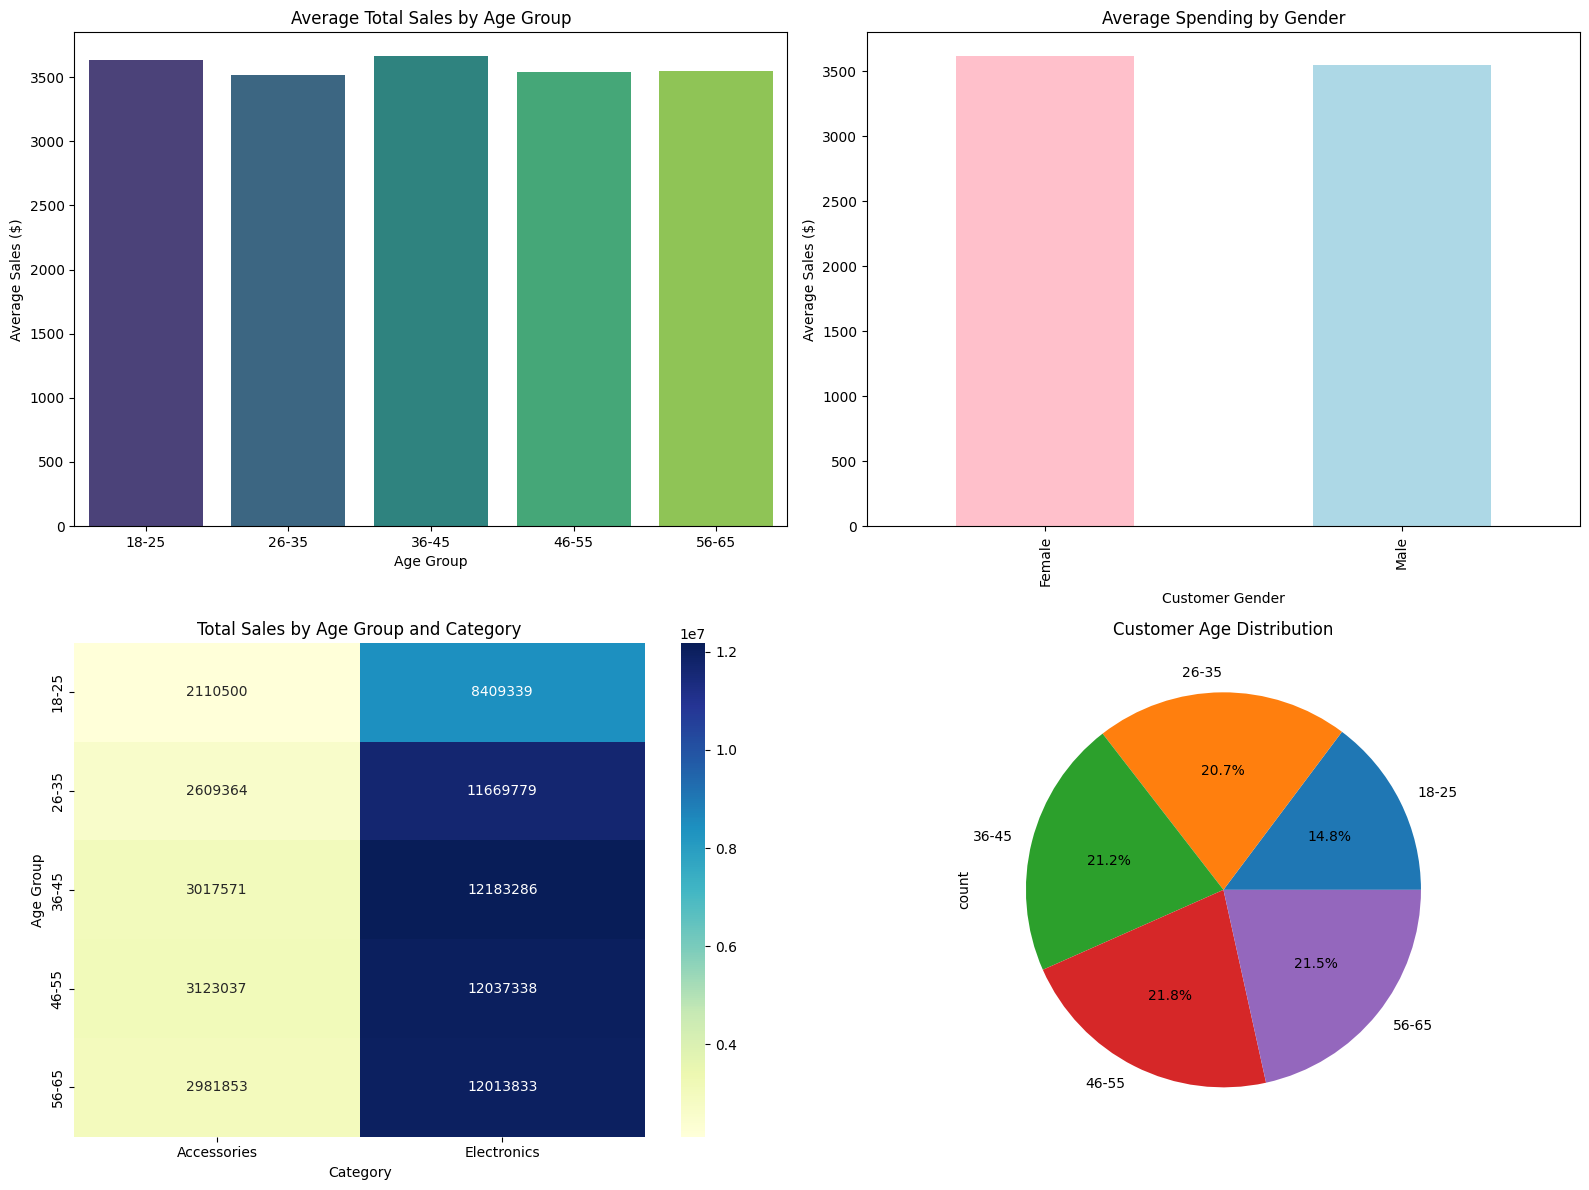

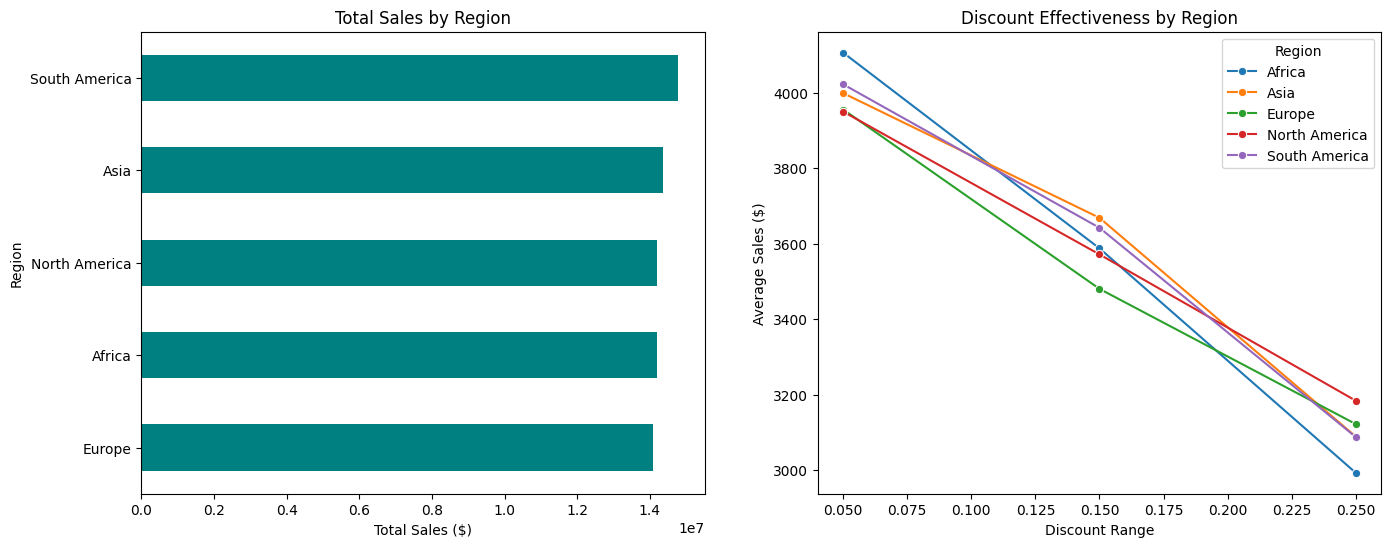

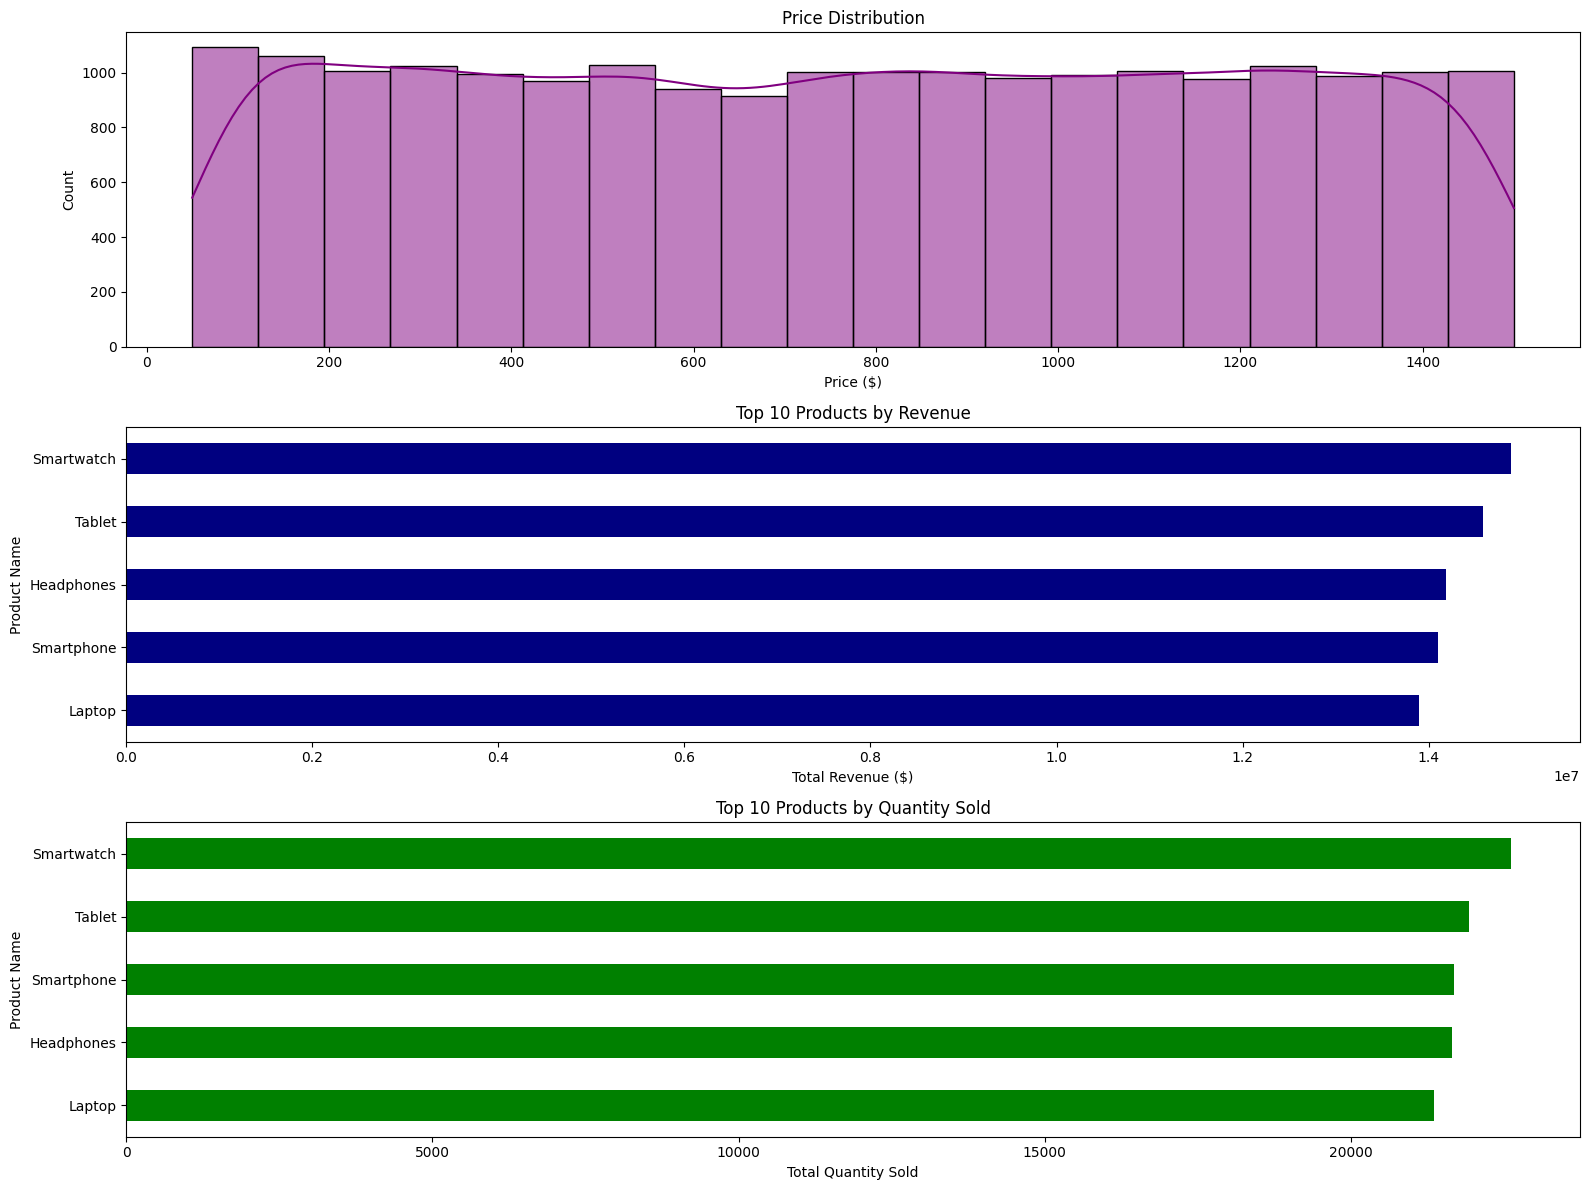

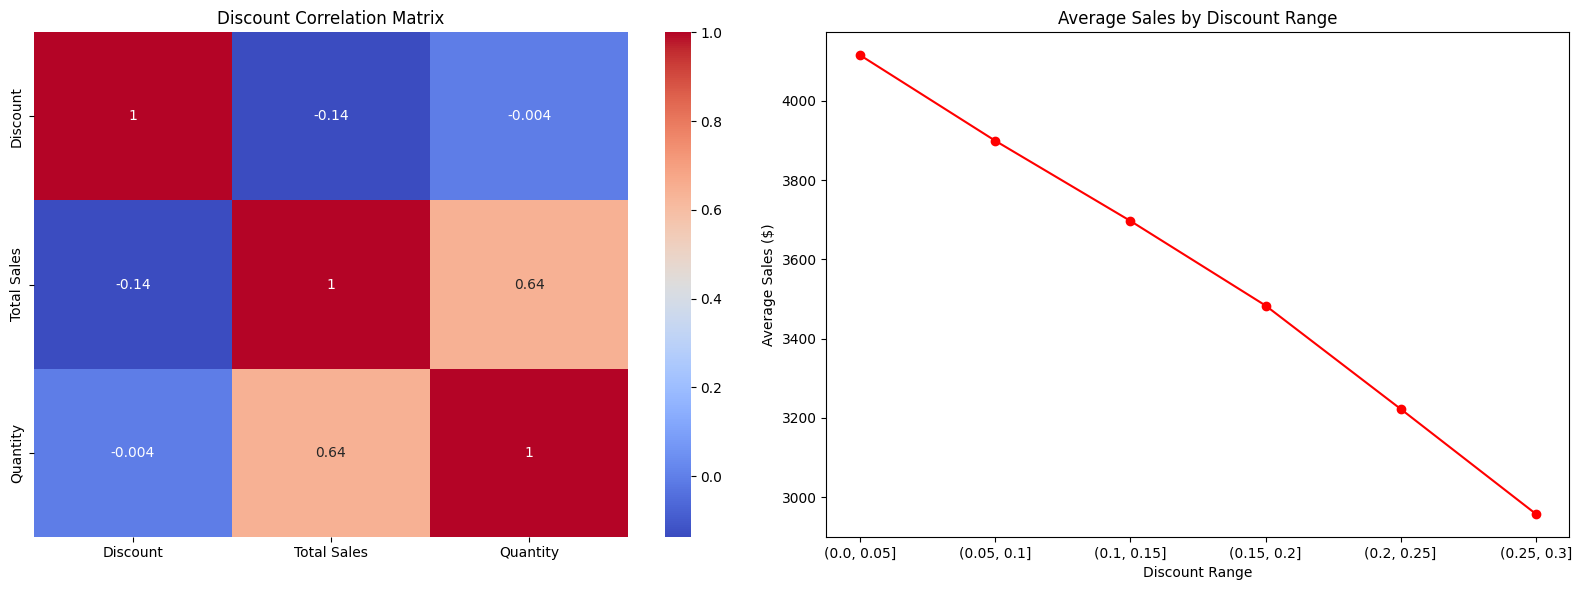

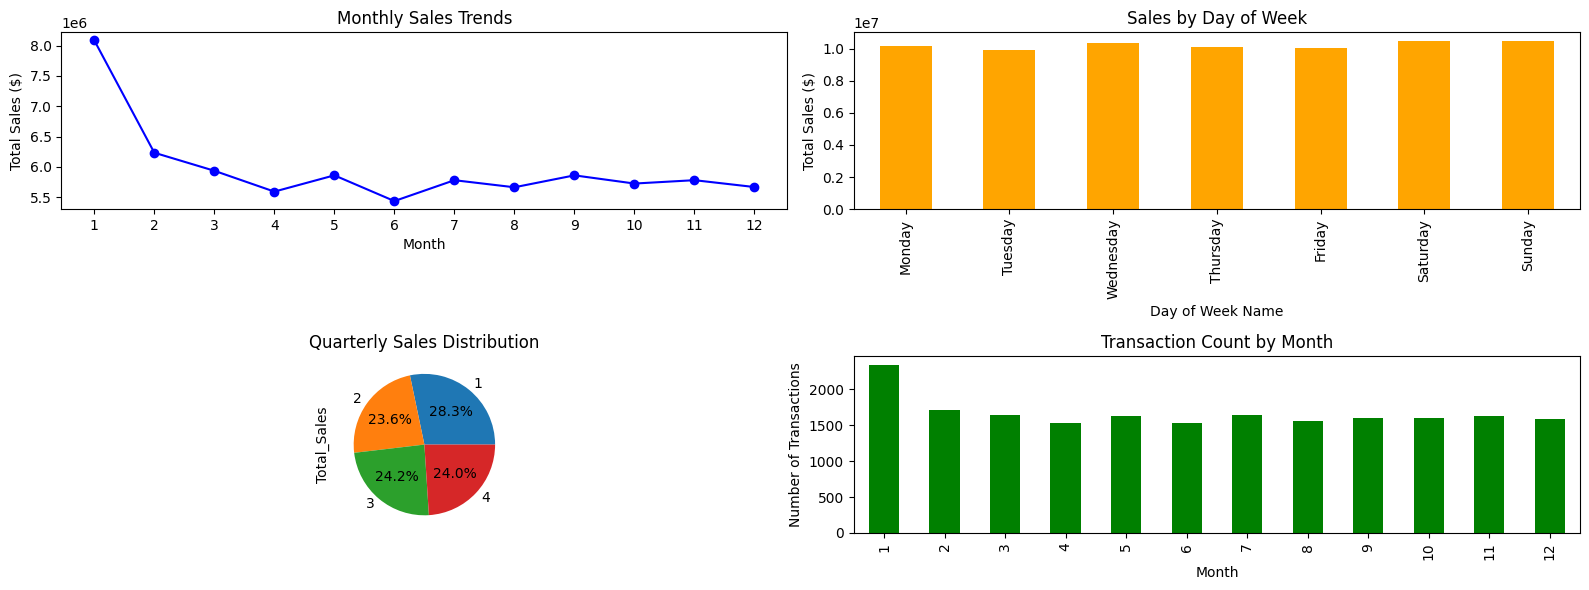

Report successfully created!


In [95]:
with PdfPages('ecommerce_analysis_report.pdf') as pdf:
    
    fig = plt.figure(figsize=(8,6))
    plt.text(0.5, 0.5, 'E-Commerce Data Analysis Report\nAd-Hoc Insights', 
         ha='center', va='center', fontsize=20)
    plt.axis('off')
    pdf.savefig(fig)
    plt.close(fig)

    fig = plot_demographics(age_spending, gender_spending, age_category)
    pdf.savefig(fig)
    plt.close(fig)
    
    fig = plot_regional(region_stats, discount_effect)
    pdf.savefig(fig)
    plt.close(fig)
    
    fig = plot_products(top_products, price_segments)
    pdf.savefig(fig)
    plt.close(fig)
    
    fig = plot_discounts(discount_corr, discount_groups)
    pdf.savefig(fig)
    plt.close(fig)
    
    fig = plot_seasonality(monthly, dow, quarterly)
    pdf.savefig(fig)
    plt.close(fig)

print("Report successfully created!")
